<a href="https://colab.research.google.com/github/MasterBeard/Clustering_Transformer_Implementation/blob/main/Clustering_Transformer_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf

# Define index tickers
index_tickers = {
    'SPX': '^GSPC',     # S&P 500
    'IXIC': '^IXIC',    # NASDAQ Composite
    'HSI': '^HSI',      # Hang Seng Index
    'DJI': '^DJI',      # Dow Jones Industrial Average
    'FCHI': '^FCHI',    # CAC 40
    'DAXI': '^GDAXI',   # DAX
    'N225': '^N225',    # Nikkei 225
    'KS11': '^KS11',    # KOSPI
    'SENSEX': '^BSESN', # BSE Sensex
    'STOXX50': '^STOXX50E',  # EURO STOXX 50
}

# Define date ranges (removed test set)
date_ranges = {
    'train': ("2005-01-01", "2015-01-01"),
    'val': ("2015-01-02", "2019-12-31")
}

# Store feature matrices and labels for each split (including norm_features)
data_splits = {split: {'features': [], 'norm_features': [], 'labels': []} for split in date_ranges}

# Window size
window_size = 11

# Fetch and process data for each time period
for split, (start_date, end_date) in date_ranges.items():
    index_data = {}
    for name, ticker in index_tickers.items():
        if ticker == '000300.SS':
            index_data[name] = yf.Ticker(ticker).history(start=start_date, end=end_date)
        else:
            index_data[name] = yf.download(ticker, start=start_date, end=end_date)

    # Create feature vectors and labels for each index
    for index_name, data in index_data.items():
        if data.empty:
            continue

        # Fix multi-level column names (only possible with Ticker().history())
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        open_values = data['Open'].dropna().values
        close_values = data['Close'].dropna().values
        low_values = data['Low'].dropna().values
        high_values = data['High'].dropna().values

        for start in range(len(data) - window_size + 1):
            open_row = open_values[start:start + window_size]
            low_row = low_values[start:start + window_size]
            high_row = high_values[start:start + window_size]
            close_row = close_values[start:start + window_size]

            # Normalization factor: closing price of the second last day in the window
            normalization_factor = close_row[-2]

            # Build feature vector in open-low-high-close order
            combined = np.array([
                val for i in range(window_size)
                for val in (open_row[i], low_row[i], high_row[i], close_row[i])
            ])

            # Normalized feature vector
            norm_combined = combined / normalization_factor

            # Label is whether the last day's closing price is higher than the previous day
            label = 1 if close_row[-1] > close_row[-2] else 0

            data_splits[split]['features'].append(combined)
            data_splits[split]['norm_features'].append(norm_combined)
            data_splits[split]['labels'].append(label)

# Convert to NumPy arrays (only train and val)
train_features = np.array(data_splits['train']['features'])
train_norm_features = np.array(data_splits['train']['norm_features'])
train_labels = np.array(data_splits['train']['labels'])

val_features = np.array(data_splits['val']['features'])
val_norm_features = np.array(data_splits['val']['norm_features'])
val_labels = np.array(data_splits['val']['labels'])

# Print shapes of each dataset (only train and val)
print(f"Train features shape: {train_features.shape}")
print(f"Train norm_features shape: {train_norm_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Validation features shape: {val_features.shape}")
print(f"Validation norm_features shape: {val_norm_features.shape}")
print(f"Validation labels shape: {val_labels.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Train features shape: (24336, 44)
Train norm_features shape: (24336, 44)
Train labels shape: (24336,)
Validation features shape: (12363, 44)
Validation norm_features shape: (12363, 44)
Validation labels shape: (12363,)


In [16]:
import numpy as np
from sklearn.cluster import KMeans

# ============================================
# Utility Functions
# ============================================
def extract_normalized_daily_ohlc(matrices, epsilon=1e-6):
    """
    Extract 5-day windows (each 5×4 = 20 dimensions) from each 44-dim vector.
    A total of 7 windows are extracted from each vector.
    Each window is normalized by its 5th-to-last value (i.e., day 4's close price, flat[15]).

    Parameters:
        matrices: Input array of OHLC vectors (each 44 dimensions)
        epsilon: Small value to avoid division by zero

    Returns:
        Array of normalized windows with shape [N_samples × 7, 20]
    """
    all_windows = []

    for vec in matrices:
        # Reshape each 44-dim vector into 11 days × 4 OHLC values
        reshaped = vec.reshape(-1, 4)  # shape: (11, 4)

        # Extract sliding windows of 5 consecutive days
        for i in range(0, reshaped.shape[0] - 5 + 1):  # 7 windows total per vector
            window = reshaped[i:i+5]  # shape: (5, 4)
            flat = window.flatten()   # shape: (20,)

            # Normalize using the close price from day 4 (5th-to-last value in flattened window)
            denominator = flat[-5]  # Corresponds to flat[15], day 4's close price
            if abs(denominator) < epsilon:
                denominator = 1.0  # Prevent division by zero

            normalized = flat / denominator
            all_windows.append(normalized)

    return np.array(all_windows)  # shape: [N_samples × 7, 20]

# Extract normalized 5-day windows for each dataset
train_days = extract_normalized_daily_ohlc(train_features)
val_days = extract_normalized_daily_ohlc(val_features)

In [17]:
from sklearn.cluster import KMeans

# Number of clusters for K-means
alternative_n = 40

# Initialize KMeans with specified number of clusters and fixed random state for reproducibility
kmeans_daily = KMeans(n_clusters=alternative_n, random_state=42)

# 1. First train KMeans on the full training data and predict clusters for all datasets
# Fit the model on training data and predict cluster assignments
train_clusters_flat = kmeans_daily.fit_predict(train_days)  # Original cluster results [0,1,2,...39]
# Predict clusters for validation sets using the trained model
val_clusters_flat = kmeans_daily.predict(val_days)

# 2. Reshape the flat cluster assignments into groups of 7 (since we extracted 7 windows per sample)
# This converts the flat array into a 2D array where each row represents the 7 window clusters for one original sample
train_clusters = train_clusters_flat.reshape(-1, 7)
val_clusters = val_clusters_flat.reshape(-1, 7)

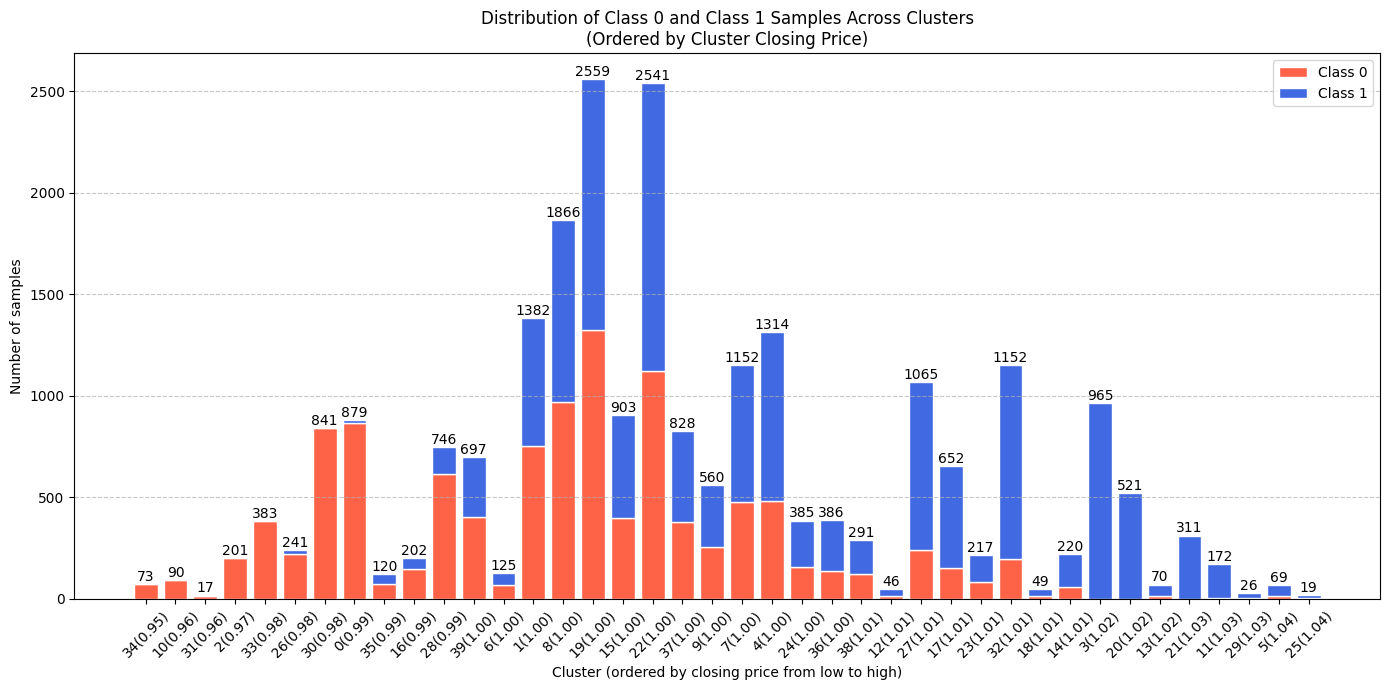


Detailed class distribution per cluster (ordered by closing price):
Cluster 34 (Close: 0.9507): 72 class 0, 1 class 1, Ratio 1/Total: 0.01
Cluster 10 (Close: 0.9554): 90 class 0, 0 class 1, Ratio 1/Total: 0.00
Cluster 31 (Close: 0.9592): 14 class 0, 3 class 1, Ratio 1/Total: 0.18
Cluster 2 (Close: 0.9654): 201 class 0, 0 class 1, Ratio 1/Total: 0.00
Cluster 33 (Close: 0.9755): 383 class 0, 0 class 1, Ratio 1/Total: 0.00
Cluster 26 (Close: 0.9802): 220 class 0, 21 class 1, Ratio 1/Total: 0.09
Cluster 30 (Close: 0.9825): 840 class 0, 1 class 1, Ratio 1/Total: 0.00
Cluster 0 (Close: 0.9853): 866 class 0, 13 class 1, Ratio 1/Total: 0.01
Cluster 35 (Close: 0.9888): 75 class 0, 45 class 1, Ratio 1/Total: 0.38
Cluster 16 (Close: 0.9909): 148 class 0, 54 class 1, Ratio 1/Total: 0.27
Cluster 28 (Close: 0.9915): 614 class 0, 132 class 1, Ratio 1/Total: 0.18
Cluster 39 (Close: 0.9975): 404 class 0, 293 class 1, Ratio 1/Total: 0.42
Cluster 6 (Close: 0.9977): 66 class 0, 59 class 1, Ratio 1/Total:

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get cluster centers and sort by closing price
cluster_centers = kmeans_daily.cluster_centers_
closing_prices = cluster_centers[:, -1]
sorted_indices = np.argsort(closing_prices)

# 2. Prepare data for plotting
# Initialize counts for class 0 and class 1 in each cluster
class0_counts = np.zeros(alternative_n)
class1_counts = np.zeros(alternative_n)

# Count class 0 and 1 in each cluster
for cluster in range(alternative_n):
    mask = (train_clusters[:,-1] == cluster)
    class0_counts[cluster] = np.sum(train_labels[mask] == 0)
    class1_counts[cluster] = np.sum(train_labels[mask] == 1)

# Reorder counts according to sorted clusters
sorted_class0 = class0_counts[sorted_indices]
sorted_class1 = class1_counts[sorted_indices]

# 3. Create stacked bar plot
plt.figure(figsize=(14, 7))
bar_width = 0.8

# Plot class 0 (bottom)
p0 = plt.bar(range(alternative_n), sorted_class0, color='tomato',
             edgecolor='white', width=bar_width, label='Class 0')

# Plot class 1 (on top of class 0)
p1 = plt.bar(range(alternative_n), sorted_class1, bottom=sorted_class0,
             color='royalblue', edgecolor='white', width=bar_width, label='Class 1')

# 4. Customize the plot
plt.xlabel('Cluster (ordered by closing price from low to high)')
plt.ylabel('Number of samples')
plt.title('Distribution of Class 0 and Class 1 Samples Across Clusters\n(Ordered by Cluster Closing Price)')

# Create x-axis labels showing cluster number and closing price
labels = [f'{i}({closing_prices[i]:.2f})' for i in sorted_indices]
plt.xticks(range(alternative_n), labels, rotation=45)

# Add value labels on top of each bar
for rect0, rect1 in zip(p0, p1):
    height0 = rect0.get_height()
    height1 = rect1.get_height()
    total = height0 + height1

    # Only show label if there are samples
    if total > 0:
        plt.text(rect0.get_x() + rect0.get_width()/2., total + 0.5,
                f'{int(total)}', ha='center', va='bottom')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Print class distribution in each cluster
print("\nDetailed class distribution per cluster (ordered by closing price):")
for i, cluster_idx in enumerate(sorted_indices):
    total = class0_counts[cluster_idx] + class1_counts[cluster_idx]
    if total > 0:
        ratio = class1_counts[cluster_idx] / total
    else:
        ratio = 0
    print(f"Cluster {cluster_idx} (Close: {closing_prices[cluster_idx]:.4f}): "
          f"{int(class0_counts[cluster_idx])} class 0, {int(class1_counts[cluster_idx])} class 1, "
          f"Ratio 1/Total: {ratio:.2f}")

In [19]:
import torch
import numpy as np

# Original reshape: Grouping every 7 windows together (from previous step)
# These are our cluster assignment matrices for each dataset
X_train = train_clusters  # shape: [n_samples, 7]
X_val = val_clusters      # shape: [n_samples, 7]

# Flatten into 1D arrays of cluster assignments
# This converts the 2D matrices into continuous sequences of cluster IDs
train_flattened = X_train.ravel()  # shape: [n_samples * 7]
val_flattened = X_val.ravel()      # shape: [n_samples * 7]

# Convert to PyTorch LongTensors (required for embedding layers)
# Using LongTensor because these are categorical cluster IDs (not float values)
train_data = torch.LongTensor(train_flattened)
val_data = torch.LongTensor(val_flattened)

# Verify the results
print(f"train_data shape: {train_data.shape}")  # Should be 1D: [total_windows]
print(f"val_data shape: {val_data.shape}")     # Should be 1D: [total_windows]

train_data shape: torch.Size([170352])
val_data shape: torch.Size([86541])


In [20]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 6  # Length of the token chunk each batch
d_model = 64  # The size of our model token embeddings
num_blocks = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 4000  # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20
max_token_value = alternative_n  # Number of iterations to average for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if it's available.
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [21]:
import os
import requests
import math
import torch.nn as nn
from torch.nn import functional as F
# Define Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.d_model, out_features=self.d_model * 4),
            nn.ReLU(),
            nn.Linear(in_features=self.d_model * 4, out_features=self.d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.ffn(x)

# Define Scaled Dot Product Attention
class Attention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones((self.context_length, self.context_length))))  # Lower triangular mask
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Time steps(current context_length), Channels(dimensions)
        assert T <= self.context_length
        assert C == self.d_model
        q = self.query_layer(x)
        k = self.key_layer(x)
        v = self.value_layer(x)

        # Scaled dot product attention: Q @ K^T / sqrt(d_k)
        weights = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Apply masked attention
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(input=weights, dim=-1)
        weights = self.dropout_layer(weights)

        # Apply dot product attention: weights @ V
        out = weights @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([Attention(head_size=self.head_size) for _ in range(self.num_heads)])
        self.projection_layer = nn.Linear(in_features=self.d_model, out_features=self.d_model)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out)
        return out

class TransformerBlock(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.head_size = d_model // num_heads  # head size should be divisible by d_model
        self.num_heads = num_heads
        self.dropout = dropout

        self.multi_head_attention_layer = MultiHeadAttention(head_size=self.head_size)
        self.feed_forward_layer = FeedForward()
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.d_model)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.d_model)

    def forward(self, x):
        # Note: The order of the operations is different from the original Transformer paper
        # The order here is: LayerNorm -> Multi-head attention -> LayerNorm -> Feed forward
        x = x + self.multi_head_attention_layer(self.layer_norm_1(x))  # Residual connection
        x = x + self.feed_forward_layer(self.layer_norm_2(x))  # Residual connection
        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.max_token_value = max_token_value
        # Set up token embedding look-up table
        self.token_embedding_lookup_table = nn.Embedding(num_embeddings=self.max_token_value, embedding_dim=self.d_model)

        # Run all the transformer blocks
        # Different from original paper, here we add a final layer norm after all the blocks
        self.transformer_blocks = nn.Sequential(*(
                [TransformerBlock(num_heads=self.num_heads) for _ in range(self.num_blocks)] +
                [nn.LayerNorm(self.d_model)]
        ))
        self.language_model_out_linear_layer = nn.Linear(in_features=self.d_model, out_features=self.max_token_value)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        """
        # Set up position embedding look-up table
        # following the same approach as the original Transformer paper (Sine and Cosine functions)
        """
        position_encoding_lookup_table = torch.zeros(self.context_length, self.d_model)
        position = torch.arange(0, self.context_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
        position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
        # change position_encoding_lookup_table from (context_length, d_model) to (T, d_model)
        position_embedding = position_encoding_lookup_table[:T, :].to(device)
        x = self.token_embedding_lookup_table(idx) + position_embedding
        x = self.transformer_blocks(x)
        # The "logits" are the output values of our model before applying softmax
        logits = self.language_model_out_linear_layer(x)

        if targets is not None:
            B, T, C = logits.shape
            logits_reshaped = logits.view(B * T, C)
            targets_reshaped = targets.view(B * T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss = None
        return logits, loss

    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            # Crop idx to the max size of positional embeddings table
            idx_crop = idx[:, -self.context_length:]

            # Get predictions
            logits, _ = self(idx_crop)  # logits: (B, T, C)

            # Get the last time step logits
            logits_last_timestep = logits[:, -1, :]  # Shape: (B, C)

            # Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1)

            # Select the most probable index for each sample in the batch
            idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Shape: (B, 1)

            # Append the sampled indices to idx
            idx = torch.cat((idx, idx_next), dim=1)  # Shape: (B, T+1)

        return idx

In [22]:
# Initialize the model
model = TransformerLanguageModel()
model = model.to(device)

# Get input embedding batch
def get_batch(split: str):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(low=0, high=np.rint((len(data)/(context_length+1))- 1).astype(np.int64), size=(batch_size,))*(context_length+1)
    x = torch.stack([data[idx:idx + context_length ] for idx in idxs]).to(device)
    y = torch.stack([data[idx +1:idx + context_length+1] for idx in idxs]).to(device)
    return x, y

# Calculate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [23]:
import copy
# Use AdamW optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()

# Early stopping parameters
best_val_loss = float('inf')
best_model_state = None
patience = 300  # Number of evaluations to wait before stopping
patience_counter = 0
early_stop = False

for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters - 1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:', step, 'Training Loss:', round(losses['train'].item(), 3),
              'Validation Loss:', round(losses['valid'].item(), 3))

        # Early stopping check
        current_val_loss = losses['valid'].item()
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_model_state = copy.deepcopy(model.state_dict()) # Save best model state
            patience_counter = 0  # Reset patience counter
            print(f"New best validation loss: {best_val_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            #print(f"No improvement in validation loss for {patience_counter}/{patience} evaluations")
            if patience_counter >= patience:
                early_stop = True
                print(f"Early stopping triggered at step {step}")
                break

    if early_stop:
        break

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Load the best model weights at the end
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights based on validation loss")

print("Training completed")

Step: 0 Training Loss: 4.03 Validation Loss: 3.995
New best validation loss: 3.9952, saving model...
Step: 20 Training Loss: 3.013 Validation Loss: 2.85
New best validation loss: 2.8505, saving model...
Step: 40 Training Loss: 2.894 Validation Loss: 2.582
New best validation loss: 2.5819, saving model...
Step: 60 Training Loss: 2.455 Validation Loss: 2.39
New best validation loss: 2.3905, saving model...
Step: 80 Training Loss: 2.361 Validation Loss: 2.271
New best validation loss: 2.2714, saving model...
Step: 100 Training Loss: 2.486 Validation Loss: 2.127
New best validation loss: 2.1266, saving model...
Step: 120 Training Loss: 2.438 Validation Loss: 2.26
Step: 140 Training Loss: 2.368 Validation Loss: 2.126
New best validation loss: 2.1261, saving model...
Step: 160 Training Loss: 2.273 Validation Loss: 2.073
New best validation loss: 2.0729, saving model...
Step: 180 Training Loss: 2.234 Validation Loss: 2.106
Step: 200 Training Loss: 2.161 Validation Loss: 2.091
Step: 220 Traini

In [27]:
import numpy as np
import pandas as pd
import zipfile
import os
from google.colab import drive

# Mount Google Drive to access dataset
drive.mount('/content/drive')
successful_stocks = 0  # Counter for successfully processed stocks

# File path configuration
zip_path = '/content/drive/My Drive/SP500_data2020-2024.zip'
extract_dir = '/content/SP500_data'

# Extract zip file containing S&P 500 stock data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

def read_sp500_csv(filepath):
    """Process specially formatted S&P 500 stock data

    Args:
        filepath: Path to CSV file

    Returns:
        DataFrame containing OHLC data

    Raises:
        ValueError if required columns are missing
    """
    # Read CSV while skipping header rows (including ticker row)
    df = pd.read_csv(filepath, header=[0,1], index_col=0, parse_dates=True)

    # Clean multi-level column names, keeping only the metric names
    df.columns = df.columns.droplevel(1)

    # Verify required OHLC columns exist
    required_cols = ['Open', 'High', 'Low', 'Close']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    return df[required_cols]

# Main processing pipeline
window_size = 11  # Size of sliding window for feature extraction
test_features1 = []  # Stores feature vectors
test_labels1 = []    # Stores binary labels (1=price increase, 0=decrease)

# Get list of all S&P 500 constituent CSV files
csv_files = sorted([f for f in os.listdir(extract_dir) if f.endswith('.csv')])
print(f"Found {len(csv_files)} S&P 500 constituent stock files")

# Process each stock file
for csv_file in csv_files[:]:  # Process all files (can limit with [:100] for first 100)
    try:
        filepath = os.path.join(extract_dir, csv_file)

        # Read and preprocess data
        ohlc = read_sp500_csv(filepath)
        if len(ohlc['Open'].values) != 0:
            successful_stocks += 1  # Count successfully processed stocks

        # Extract OHLC price series
        open_vals = ohlc['Open'].values
        high_vals = ohlc['High'].values
        low_vals = ohlc['Low'].values
        close_vals = ohlc['Close'].values

        # Create sliding windows
        for start in range(len(ohlc) - window_size):
            # Extract price window
            window_open = open_vals[start:start+window_size]
            window_high = high_vals[start:start+window_size]
            window_low = low_vals[start:start+window_size]
            window_close = close_vals[start:start+window_size]

            # Create feature vector in Open-Low-High-Close order
            feature_vec = np.array([
                val for i in range(window_size)
                for val in (window_open[i], window_low[i], window_high[i], window_close[i])
            ])

            # Create binary label (1 if price increased, 0 otherwise)
            label = 1 if window_close[-1] > window_close[-2] else 0

            test_features1.append(feature_vec)
            test_labels1.append(label)

    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")
        continue

# Convert to NumPy arrays and reshape features
test_features1 = np.array(test_features1)
test_features1 = np.expand_dims(test_features1, axis=-1)  # Reshape from (N,44) to (N,44,1)
test_labels1 = np.array(test_labels1)

# Output results
print("\nTest set generation results:")
print(f"Successfully processed stocks: {successful_stocks}")
print(f"Feature matrix shape: {test_features1.shape}")
print(f"Label distribution - Up: {np.mean(test_labels1):.1%}, Down: {1-np.mean(test_labels1):.1%}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 501 S&P 500 constituent stock files

Test set generation results:
Successfully processed stocks: 501
Feature matrix shape: (606191, 44, 1)
Label distribution - Up: 51.8%, Down: 48.2%


In [25]:
test_days_spx = extract_normalized_daily_ohlc(test_features1)
test_clusters_flat_spx = kmeans_daily.predict(test_days_spx)
test_clusters_spx = test_clusters_flat_spx.reshape(-1, 7)

In [26]:
import numpy as np
import torch
from tqdm import tqdm  # For progress bars
from sklearn.metrics import confusion_matrix

# Initialization
batch_size = 30000  # Process data in batches to manage memory usage
predictions_dict = {
    "top9": [],  # Will store predictions considering top 9 classes
    "top8": [],
    "top7": [],
    "top6": [],
    "top5": [],
    "top4": [],
    "top3": [],  # Typically most important for final evaluation
    "top2": [],
    "top1": []   # Basic single-class prediction
}

# Batch prediction with progress bar
for i in tqdm(range(0, len(test_clusters_spx), batch_size)):
    model.eval()  # Set model to evaluation mode

    # Prepare batch (excluding last token since we're predicting it)
    batch = test_clusters_spx[i:i+batch_size, :-1]
    start_ids = torch.tensor(batch, dtype=torch.long, device=device)

    # Generate predictions - we only need 1 new token prediction
    y = model.generate(start_ids, max_new_tokens=1)
    predicted_tokens = y[:, -1]  # Get the predicted tokens

    # Check if predictions are in top-N classes
    for N, key in zip([9,8,7,6,5,4,3,2,1],
                     ["top9","top8","top7","top6","top5","top4","top3","top2","top1"]):
        # Get top-N classes (assuming sorted_indices contains class indices in order)
        topn = torch.tensor(sorted_indices[-N:], device=device)
        # Check which predictions are in top-N
        in_topn = torch.isin(predicted_tokens, topn).long()
        predictions_dict[key].extend(in_topn.cpu().tolist())

# =============================
# Save top3 predictions as .npy file
# =============================
# Uncomment to save:
# np.save("top3_predictions2020.npy", np.array(predictions_dict["top3"]))
# print("Top3 predictions saved to: top3_predictions2020.npy")

# =============================
# Evaluation against true labels
# =============================
def evaluate(predictions, true_labels, name=""):
    """Evaluate prediction performance with multiple metrics

    Args:
        predictions: List of predicted labels (0/1)
        true_labels: List of ground truth labels (0/1)
        name: Identifier for the evaluation case
    """
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate basic accuracy
    accuracy = np.mean(predictions == true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=[0,1])
    tp = cm[1,1]  # True positives
    fp = cm[0,1]  # False positives
    fn = cm[1,0]  # False negatives

    # Calculate precision, recall, F1 with safety checks
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Print comprehensive evaluation
    print(f"--- Evaluation for {name} ---")
    print(f"Accuracy:  {accuracy:.2%}")  # Percentage with 2 decimals
    print(f"Precision: {precision:.2%}")  # TP / (TP + FP)
    print(f"Recall:    {recall:.2%}")     # TP / (TP + FN)
    print(f"F1 Score:  {f1:.2%}")        # Harmonic mean of precision/recall
    print(f"Confusion Matrix:\n{cm}\n")  # Show the full matrix

# Run evaluation for each top-N case
for key in predictions_dict:
    evaluate(predictions_dict[key], test_labels1, name=key)

100%|██████████| 21/21 [03:16<00:00,  9.35s/it]


--- Evaluation for top9 ---
Accuracy:  49.05%
Precision: 53.42%
Recall:    12.22%
F1 Score:  19.89%
Confusion Matrix:
[[259002  33436]
 [275414  38339]]

--- Evaluation for top8 ---
Accuracy:  49.05%
Precision: 53.72%
Recall:    11.32%
F1 Score:  18.69%
Confusion Matrix:
[[261850  30588]
 [278248  35505]]

--- Evaluation for top7 ---
Accuracy:  48.79%
Precision: 54.45%
Recall:    6.49%
F1 Score:  11.60%
Confusion Matrix:
[[275406  17032]
 [293391  20362]]

--- Evaluation for top6 ---
Accuracy:  48.79%
Precision: 54.45%
Recall:    6.48%
F1 Score:  11.59%
Confusion Matrix:
[[275425  17013]
 [293415  20338]]

--- Evaluation for top5 ---
Accuracy:  48.81%
Precision: 55.30%
Recall:    5.76%
F1 Score:  10.44%
Confusion Matrix:
[[277825  14613]
 [295677  18076]]

--- Evaluation for top4 ---
Accuracy:  48.73%
Precision: 55.07%
Recall:    5.11%
F1 Score:  9.35%
Confusion Matrix:
[[279364  13074]
 [297731  16022]]

--- Evaluation for top3 ---
Accuracy:  48.43%
Precision: 60.93%
Recall:    1.00%
